Major Imports

In [1]:
import torch
import numpy as np
import pandas as pd
import os
from os import listdir
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
#import cv2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
# %matplotlib inline
#import imutils

from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Conv2D,Input,ZeroPadding2D,BatchNormalization,Flatten,Activation,Dense,MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle #shuffling the data improves the model
import warnings

SEED = 123
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
#torch.cuda.manual_seed_all(SEED)
warnings.filterwarnings("ignore", "Lazy modules are a new feature.*")

from torch import nn,optim
from torchvision import transforms as T,datasets,models
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from collections import OrderedDict
from tqdm import tqdm
pd.options.plotting.backend = "plotly"
from torch.autograd import Variable
from torchvision.utils import save_image
import torchsummary
#from torchvision import imshow
# import cleanlab
# from cleanlab.classification import CleanLearning
# from cleanlab.benchmarking import noise_generation
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from numpy.random import multivariate_normal
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from matplotlib.image import imread
import seaborn as sns
import random
#import cv2
import copy
from sklearn.model_selection import train_test_split
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from PIL import Image

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from torch.utils.data.sampler import SubsetRandomSampler  # For validation set

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Data directory for mislabeled data. Contains training, validation, and test data.

data_dir = "/home/tejoman/Documents/Cleanlab Pytorch Pneumonia/archive_test/chest_xray/"
data_dir = "/home/tejoman/Documents/Cleanlab Pytorch Pneumonia/archive_test_100 to 1/chest_xray/"
data_dir = "/home/tejoman/Documents/Cleanlab Pytorch Pneumonia/archive_test_50 to 1/chest_xray/"
data_dir = "/home/tejoman/Documents/Cleanlab Pytorch Pneumonia/archive_test_10 to 1/chest_xray/"
data_dir = "/home/tejoman/Documents/Cleanlab Pytorch Pneumonia/archive_test_5 to 1/chest_xray/"
data_dir = "/home/tejoman/Documents/Cleanlab Pytorch Pneumonia/archive_test_2 to 1/chest_xray/"
data_dir = "C:\\Users\\Small\\OneDrive\\Documents\\chest_xray\\"
data_dir = "C:\\Users\\Small\\OneDrive\\Documents\\Cleanlab Testing\\test_10_to_1\\chest_xray\\"

Model-Related Functions

In [2]:
# def data_transforms(phase = None):

#     if phase == TRAIN:

#         data_T = T.Compose([

#                 T.Resize(size = (224,224)),
#                 #T.RandomRotation(degrees = (-20,+20)),
#                 #T.CenterCrop(size=224),
#                 T.ToTensor(),
#                 T.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
#         ])

#     elif phase == TEST or phase == VAL:

#         data_T = T.Compose([

#                 T.Resize(size = (224,224)),
#                 T.ToTensor(),
#                 T.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
#         ])

#     return data_T


#Visualize some images
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:60], nrow=10).permute(1, 2, 0))
        break


def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds)), preds


def train(model, loaders, criterion, optimizer, scheduler, epochs):
  # loaders is a dictionary with keys "train" and "val"
  since = time.time()
  best_model = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  for epoch in range(epochs):
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()

      running_loss = 0.0
      running_corrects = 0.0

      for inputs, labels in loaders[phase]:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase=='train'):
          outp = model(inputs)
          _, pred = torch.max(outp, 1)
          loss = criterion(outp, labels)

          if phase == 'train':
            loss.requires_grad = True
            loss.backward()
            optimizer.step()

        running_loss += loss.item()*inputs.size(0)
        running_corrects += torch.sum(pred == labels.data)


      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double()/dataset_sizes[phase]
      losses[phase].append(epoch_loss)
      accuracies[phase].append(epoch_acc)
      if phase == 'train':
        print('Epoch: {}/{}'.format(epoch+1, epochs))
      print('{} - loss:{}, accuracy{}'.format(phase, epoch_loss, epoch_acc))

      if phase == 'val':
        print('Time: {}m {}s'.format((time.time()- since)//60, (time.time()- since)%60))

      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model = copy.deepcopy(model.state_dict())
    scheduler.step()
  time_elapsed = time.time() - since
  print('Training Time {}m {}s'.format(time_elapsed//60, time_elapsed%60))
  print('Best accuracy {}'.format(best_acc))

  model.load_state_dict(best_model)
  return model


  #Running on test data
def validation_step(batch):
        images,labels = batch
        images,labels = images.to(device),labels.to(device)
        out = model(images)
        loss = F.cross_entropy(out, labels)
        acc,preds = accuracy(out, labels)

        return {'val_loss': loss.detach(), 'val_acc':acc.detach(),
                'preds':preds.detach(), 'labels':labels.detach()}




def test_prediction(outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        # combine predictions
        batch_preds = [pred for x in outputs for pred in x['preds'].tolist()]
        # combine labels
        batch_labels = [lab for x in outputs for lab in x['labels'].tolist()]

        return {'test_loss': epoch_loss.item(), 'test_acc': epoch_acc.item(),
                'test_preds': batch_preds, 'test_labels': batch_labels}


@torch.no_grad()
def test_predict(model, test_loader):
    model.eval()
    # perform testing for each batch
    outputs = [validation_step(batch) for batch in test_loader]
    results = test_prediction(outputs)
    print('test_loss: {:.4f}, test_acc: {:.4f}'
          .format(results['test_loss'], results['test_acc']))

    return results['test_preds'], results['test_labels']

Labeling Error Related Functions

Attempt at Generalizability

In [3]:
import sklearn
from sklearn.covariance import MinCovDet

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels

class ALED(sklearn.base.BaseEstimator, sklearn.base.ClassifierMixin):
    # BaseEstimator provides get and set_params() functions and ClassifierMixin provides weighted accuracy

    def __init__(self, random_state = 0): # random_state is default 0 for now, should be changed later!
        # Note: I think the sklearn API would say that some fit() params [e.g., model, max_pca_components, max_pca_variance]
        #   should be instantiation params and not fit() params

        self.random_state = random_state

    @staticmethod
    def sum_until(in_list, threshold):
        """
        Helper function for fit()
        """
        count = 0
        for n in range(len(in_list)):
            if count < threshold:
                count += in_list[n]
            else:
                break
        return count, n+1

    @staticmethod
    def gaussian_likelihood(cov_matrix, mahalanobis_squared_dist):
        """
        Helper function for fit()
        """
        n = cov_matrix.shape[0]
        sqrt_det = np.sqrt(np.linalg.det(cov_matrix))
        prob_x_f = ( 1 / ( (2*np.pi)**(n/2) * sqrt_det ) ) * np.exp(-0.5*mahalanobis_squared_dist)
        if prob_x_f > 1: print("prob_x_f > 1; prob_x_f =", prob_x_f)
        return prob_x_f

    def extract_conv_net_features(self, conv_net, dataset):
        """
        Helper function for fit()
        """
        pass

    def map_conv_net_output(self):
        """
        Map the last layer of the convolutional layer (or other last feature extraction layer)
        so each sample ends up with 1 dimension of representative features
        """
        pass


    def extract_out_label(self, prediction_stats_row):
        given_label = prediction_stats_row['given label (name)']
        probabilities_row = np.array([prediction_stats_row["p(k = {} | x)".format(class_i)] for class_i in self.classes_])
        if (self.classes_[probabilities_row.argmax()] != given_label)\
           and (probabilities_row.max()/prediction_stats_row["p(k = {} | x)".format(given_label)] > self.likelihood_ratio_threshold):
            return self.classes_[probabilities_row.argmax()]
        else:
            return given_label

    def fit_predict(self, model, dataset, device=None, max_pca_components=10, max_pca_variance=0.25, likelihood_ratio_threshold=2, prob_method="gaussian", batch_size=100):
        # sklearn would want us to separate into fit() and predict() (NR)
        """
        Given a model and data, outputs predicted class for each sample based on ALED algorithm.
        Creates a new model that aggregates input classification model features / feature maps at last layer before classification into a [p x 1] vector.
        Then performs PCA to generate an [n x 1] vector of PCs, where n is specified either explicitly or by a desired level of explained variance. Then
        the probability that a given sample belongs to the assigned class is assessed using Bayes' rule, and if the probability falls below the within
        class threshold, then the sample is compared to the other class(es), and if the probability that it belongs in another class is higher than the
        out of class threshold, then the sample is added to an output DataFrame containing suspect samples and their associated probabilities. This
        function is dependent on the ability of the input classification model to extract salient features from the input data and thus should only be
        applied if the model is achieving some threshold auc / accuracy.

        ### Parameters
        1. model : Pytorch model (torch.nn.Sequential)
            -A classification model
        2. dataset : Pytorch Dataset (torch.utils.data.Dataset, eventually...right now needs an ImageFolder)
            -The dataset used to train model
             note: the dataset is responsible for holding any transformation functions;
             the transformations need to be the same transformations done for model evaluation; data augmentation should NOT be used!!!
        x. device : str, or None
            -Specifies device (e.g. 'cuda' GPU) to be used for processing
        4. max_pca_components : int
            -Maximum number of components used for PCA (10 by default);
             determines
        5. pca_variance : float
            -Ratio of explained variance desired, if
             using explained variance method (0.25 by
             default)
        6. wc_threshold : float
            -Within class threshold to consider sample
             within distribution of other class(es) (0.05
             by default)
        7. ooc_threshold : float
            -Out of class threshold to see whether flagged
             samples belong to other class(es) (0.95 by
             default)
        8. prob_method : str
            -Method to use for calculating the likelihood,
             either specify a distribution type or use a
             non-parametric estimator ("gaussian" is
             default)
        9. data_transforms : func
            -Any data transformations performed prior to use
             by the model # specify torchvision transforms (NR)

        ### Returns
        1. label_issues_df : Pandas DataFrame (pd.DataFrame)
            -A DataFrame containing the samples that are
             suspected label errors and their associated
             probabilities of belonging to each class,
             as calculated by the above methods

        ### Raises
        ______
        We'll get to that

        ### object attributes created:
        - self.conv_net
        - self.X_
        - self.y_
        - self.classes_
        - self.pca
        - self.num_pca_components
        - self.pca_explained_variance
        - self.X_pca_tf
        - self.c
        - self.prediction_stats

        """
        # Define Adaptive Labeling Error Detection (ALED) feature extraction model
        # I changed "ALED_model" to "self.conv_net"; please don't kill me; I think CNN, conv_net, or FEM are better names (NR)
        self.conv_net = nn.Sequential(*list(model.children())[:-1])
        # I think this^ won't work for all models; maybe we do a deep recursive dive into model.modules() or
        #    model.children() to identify the last layer of type conv (NR)

        self.conv_net.avgpool = torch.nn.AdaptiveAvgPool2d((1,1)) # Feature pooling of feature maps, probably will need to add another method for 1d and 3d features
        print(self.conv_net)
        # Create sorted representation of data (right now only works on images in chest x-ray dataset):

        BATCH_SIZE = batch_size # maybe a param?
        dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

        feat_array = None # will be initialized once we know size of
        y = np.zeros(len(dataset))
        for batch_num, (inputs, labels) in enumerate(dataloader):
            # note: the dataset is responsible for holding any transformation functions;
            # the transformations need to be the same transformations done for model evaluation; data augmentation should NOT be used!!!

            batch_cuda = inputs.to(device)
            batch_feat = self.conv_net(batch_cuda)
            batch_feat_cpu = batch_feat.to('cpu').squeeze() # this might need to be changed - can we assume user wants to use 'cpu'?
            # return batch_feat_cpu
            if feat_array is None:
                feat_array = np.zeros((len(dataset), *batch_feat_cpu.shape[1:]))

            feat_array[batch_num*BATCH_SIZE : batch_num*BATCH_SIZE + len(batch_feat_cpu)] = batch_feat_cpu
            y[         batch_num*BATCH_SIZE : batch_num*BATCH_SIZE + len(batch_feat_cpu)] = labels

            del batch_cuda
            del batch_feat

        # feat_array.squeeze()

        print("feat_array.shape, y.shape:", feat_array.shape, y.shape)
        # Check that X and y have correct shape
        feat_array, y = check_X_y(feat_array, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)

        self.X_ = feat_array
        self.y_ = y
#         self.sample_weights = sample_weight # might need sample_weight param for compatibility with sklearn - document if ignored

        # perform PCA
        from sklearn.decomposition import PCA
        self.pca = PCA(n_components = max_pca_components) # don't rename this - we overwrite this variable 3 lines later
        self.pca.fit(feat_array)
        calc_var, max_variance_num_comps = self.sum_until(self.pca.explained_variance_ratio_, max_pca_variance)
        self.pca = PCA(n_components = min(max_pca_components, max_variance_num_comps)).fit(feat_array)
        self.X_pca_tf = self.pca.transform(feat_array) # pca_tf means pca transformed

        # optional (could be helpful for user):
        self.num_pca_components = self.pca.n_components_
        self.pca_explained_variance = calc_var

        # Calculate covariance matrices for all class distributions
        self.num_classes = len(self.classes_)
        self.class_indices_dict = {}
        self.priors_dict = {}
        self.PC_dict = {}
        self.cov_dict = {}

        for class_i in self.classes_:
            class_indices = np.array(np.arange(len(feat_array))[y == class_i])
            self.class_indices_dict["class{}_indices".format(class_i)] = class_indices
            class_PC_array = self.X_pca_tf[class_indices, :]
            self.PC_dict["class{}_PC_array".format(class_i)] = class_PC_array
            self.cov_dict["robust_cov{}".format(class_i)] = MinCovDet(random_state=self.random_state).fit(class_PC_array)

        # Calculate prior probabilities
        for class_i in self.classes_:
            prior = len(self.class_indices_dict["class{}_indices".format(class_i)]) / len(y)
            self.priors_dict["prior_prob{}".format(class_i)] = prior

        # Calculate likelihoods
        likelihoods_df_dict = {}
        for class_i in self.classes_:
            likelihoods_dict = {}
            for class_j in self.classes_:
                cov_matrix = self.cov_dict["robust_cov{}".format(class_j)].covariance_ #raw_covariance_ # why do we use raw_covariance_ instead of covariance_? (NR)
                cov_mahalanobis = self.cov_dict["robust_cov{}".format(class_j)].mahalanobis(self.PC_dict["class{}_PC_array".format(class_i)]) # I think this was redundant; see MinCovDet.dist_ (NR)
                likelihoods_dict["p(x | k = {})".format(class_j)] = np.array([self.gaussian_likelihood(cov_matrix, sample) for sample in cov_mahalanobis])
                # mahalanobis_distances = self.cov_dict["robust_cov{}".format(class_j)].dist_
                # likelihoods_dict["p(x | k = {})".format(class_j)] = np.array([self.gaussian_likelihood(cov_matrix, sample**2) for sample in mahalanobis_distances])
            likelihoods_df = pd.DataFrame.from_dict(likelihoods_dict).set_index(self.class_indices_dict["class{}_indices".format(class_i)])
            likelihoods_df_dict["likelihood_df{}".format(class_i)] = likelihoods_df

        # Calculate probabilities
        final_dfs_list = []
        for class_i in self.classes_:
            likelihoods_df = likelihoods_df_dict["likelihood_df{}".format(class_i)]
            for class_j in self.classes_:
                likelihoods_df["p(k = {} | x)".format(class_j)] = likelihoods_df["p(x | k = {})".format(class_j)] * self.priors_dict["prior_prob{}".format(class_j)] / \
                    sum( [likelihoods_df["p(x | k = {})".format(class_k)] * self.priors_dict["prior_prob{}".format(class_k)] for class_k in self.classes_] )
#             likelihoods_df["given label (num)"] = n
            likelihoods_df["given label (name)"] = class_i
            # likelihoods_df["updated label (name)"] =
            final_dfs_list.append(likelihoods_df)

        self.prediction_stats = pd.concat(final_dfs_list).sort_index()
        self.likelihood_ratio_threshold = likelihood_ratio_threshold
        self.prediction_stats['out-label'] = self.prediction_stats.apply(self.extract_out_label, axis=1)

        return self.prediction_stats['out-label']


#### ALED testing dataset definition

In [4]:
from sklearn.utils.multiclass import unique_labels

class Mislabeling_Dataset(Dataset):
    """
    a Dataset class that contains a Dataset, providing the data of the internal Dataset
    but with labeling errors
    """
    def __init__(self, internal_dataset, internal_dataset_labels = None, fraction_mislabeled = 0.1, random_state = None):

        super().__init__()
        self.internal_dataset = internal_dataset
        self.true_labels = copy.deepcopy(internal_dataset_labels)
        if self.true_labels is None:
            self.set_true_labels()
        elif len(self.true_labels) != len(internal_dataset):
          raise Exception("Must have same number of labels as the length of the dataset [i.e. len(internal_dataset_labels) == len(internal_dataset)]")
        self.classes = unique_labels(self.true_labels)
        self.fraction_mislabeled = fraction_mislabeled
        self.rng = np.random.default_rng(random_state)
        # could potentially add a parameter to choose what method to mislabel (e.g., completely random, half mislabeled from each class)


        self.mislabel_sample_inds = self.rng.choice(np.arange(len(self.internal_dataset)), size=int(self.fraction_mislabeled*len(internal_dataset)), replace=False)
        mislabel_maps = [[class_j for class_j in self.classes if class_j != class_i] for class_i in self.classes]

        self.labels = copy.deepcopy(self.true_labels)
        for ind in self.mislabel_sample_inds:
            self.labels[ind] = mislabel_maps[self.true_labels[ind]][self.rng.integers(len(self.classes)-1)]


    def set_true_labels(self):
        # helper function used by __init__()
        self.true_labels = np.zeros(len(self.internal_dataset), dtype=object)
        for i in range(len(self.internal_dataset)):
            self.true_labels[i] = self.internal_dataset[i][1]

    # def __getattr__(self, attr):
    #     # wrapping an object; source: https://code.activestate.com/recipes/577555-object-wrapper-class/
    #     if attr in self.__dict__:
    #         return getattr(self, attr)
    #     return getattr(self.internal_dataset, attr)

    def __getitem__(self, idx):
        return self.internal_dataset[idx][0], self.labels[idx]

    def __len__(self):
        return len(self.internal_dataset)

# the following is a more complicated, incomplete version of class Mislabeling_Dataset that will work faster when loading the data takes a long time
"""
class Mislabeling_Dataset2(Dataset):
    "
    a Dataset class that contains a Dataset, providing the data of the internal Dataset
    but with labeling errors
    "
    def __init__(self, internal_dataset, classes, fraction_mislabeled = 0.1, random_state = None):
        "
        classes is list of the class labels [unless there's an easy way to access this from internal_dataset]
        "
        super().__init__()
        self.internal_dataset = internal_dataset
        self.classes = classes
        self.fraction_mislabeled = fraction_mislabeled
        self.rng = np.random.default_rng(random_state)
        # could potentially add a parameter to choose what method to mislabel (e.g., completely random, half mislabeled from each class)

        # choose which samples to mislabel:
        self.mislabel_sample_inds = self.rng.choice(np.arange(len(self.internal_dataset)), size=int(self.fraction_mislabeled*len(internal_dataset)), replace=False)
        # mislabel_sample_indicator[ind] is -1 if true value, or a mapping value [0, len(classes)-1] if we should output incorrect
        self.mislabel_sample_indicator = np.ones(len(self.internal_dataset), dtype=int)*(-1)
        for ind in self.mislabel_sample_inds:
            self.mislabel_sample_indicator[ind] = self.rng.integers(len(classes)-1)

        self.mislabel_maps = [copy.deepcopy(self.classes).remove(class_i) for class_i in self.classes]

    def __getitem__(self, idx):
        if self.mislabel_sample_indicator[ind] == -1:
            return self.internal_dataset[idx]
        else:
            item, correct_label = self.internal_dataset[idx]
            return self.internal_dataset[idx][0], self.mislabel_maps[correct_label][self.mislabel_sample_indicator[ind]]
"""

'\nclass Mislabeling_Dataset2(Dataset):\n    "\n    a Dataset class that contains a Dataset, providing the data of the internal Dataset\n    but with labeling errors\n    "\n    def __init__(self, internal_dataset, classes, fraction_mislabeled = 0.1, random_state = None):\n        "\n        classes is list of the class labels [unless there\'s an easy way to access this from internal_dataset]\n        "\n        super().__init__()\n        self.internal_dataset = internal_dataset\n        self.classes = classes\n        self.fraction_mislabeled = fraction_mislabeled\n        self.rng = np.random.default_rng(random_state)\n        # could potentially add a parameter to choose what method to mislabel (e.g., completely random, half mislabeled from each class)\n\n        # choose which samples to mislabel:\n        self.mislabel_sample_inds = self.rng.choice(np.arange(len(self.internal_dataset)), size=int(self.fraction_mislabeled*len(internal_dataset)), replace=False)\n        # mislabel_s

## MNIST dataset setup

In [5]:
from google.colab import drive
# drive.mount('/content/drive')

In [6]:
# Code taken in part from: https://github.com/vincent6606/DenseNet/blob/master/MNIST%2BDensnet.ipynb
!ls gdrive/MyDrive/"'Colab Notebooks'"
# !ls drive/MyDrive/'Colab Notebooks'/MNIST
# !mkdir drive/MyDrive/'Colab Notebooks'/'MNIST'

# later, will need to figure out how to adapt Mislabeling_Dataset with RandomCrop and other data augmentation
# mnist_trainTransform = transforms.Compose([
#     transforms.RandomCrop(28, padding=4),
#     transforms.ToTensor(),
#     transforms.Normalize((0.1307,), (0.3081,))
# ])

# mnist_testTransform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.1307,), (0.3081,))
# ])

mnist_transform = transforms.Compose([
    # T.Grayscale(num_output_channels=3),
    # T.Resize(size = (224,224)),
    transforms.ToTensor(),
    # transforms.Normalize((0.1307,), (0.3081,))
    # T.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    # T.Normalize([0.485],[0.229])
    T.Normalize(0, 1)
])

mnist_trainset = torchvision.datasets.MNIST("./drive/MyDrive/'Colab Notebooks'/MNIST",
    train=True,
    transform=mnist_transform,
    download=True)

mnist_trainset_mislabeled = Mislabeling_Dataset(mnist_trainset, internal_dataset_labels=mnist_trainset.targets, fraction_mislabeled=0.1, random_state=0)

mnist_testset = torchvision.datasets.MNIST("./drive/MyDrive/'Colab Notebooks'/MNIST",
    train=False, # test
    transform=mnist_transform,
    download=True)

print(dir(mnist_trainset))
mnist_trainset.test_labels



BATCH_SIZE = 1000

mnist_trainLoader = DataLoader(
    dataset=mnist_trainset,
    batch_size=BATCH_SIZE,
    shuffle=True)

# mnist_trainLoader = DataLoader(
#     dataset=mnist_trainset_mislabeled,
#     batch_size=BATCH_SIZE,
#     shuffle=True)


mnist_testLoader = DataLoader(
        dataset=mnist_testset,
        batch_size=BATCH_SIZE,
        shuffle=False)

for data, labels in mnist_trainLoader:
    # print(data, labels)
    print(data.shape, labels.shape)
    break


# trying to just learn 1s and 2s but the following destroyed the dataset:
# for ds in [mnist_trainset, mnist_testset]:
#     idx = (ds.targets==1) & (ds.targets==2)
#     print(mnist_trainset.targets)
#     print(idx)
#     ds.targets = ds.targets[idx]
#     ds.data = ds.data[idx]

# idx = (mnist_trainset.targets==1) & (mnist_trainset.targets==2)
# print(mnist_trainset.targets)
# print(idx)
# mnist_trainset.targets = mnist_trainset.targets[idx]
# mnist_trainset.data = mnist_trainset.data[idx]

# np.arange(len(mnist_trainset))[mnist_trainset.targets == 1]
# mnist_trainset[[5, 6]]

MNIST
['__add__', '__annotations__', '__class__', '__class_getitem__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__orig_bases__', '__parameters__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_check_exists', '_check_legacy_exist', '_format_transform_repr', '_is_protocol', '_load_data', '_load_legacy_data', '_repr_indent', 'class_to_idx', 'classes', 'data', 'download', 'extra_repr', 'mirrors', 'processed_folder', 'raw_folder', 'resources', 'root', 'target_transform', 'targets', 'test_data', 'test_file', 'test_labels', 'train', 'train_data', 'train_labels', 'training_file', 'transform', 'transforms']
torch.Size([1000, 1, 28, 28]) torch.Size([1000])


/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


percent purposely mislabeled =  0.09999999999999998
[0 1 2 3 4 5 6 7 8 9]
[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9 4 0 9 1 1 2 4 3 2 7]
[5 0 4 1 9 2 1 3 1 4 3 3 4 6 1 7 2 3 6 9 9 0 9 1 1 2 4 3 9 7]


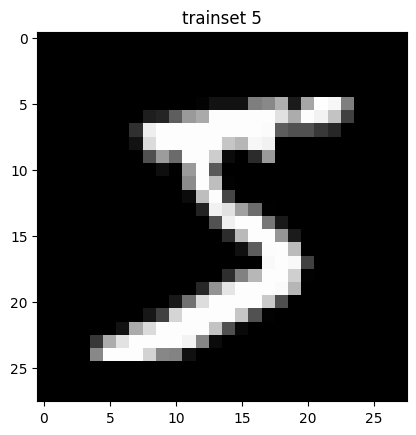

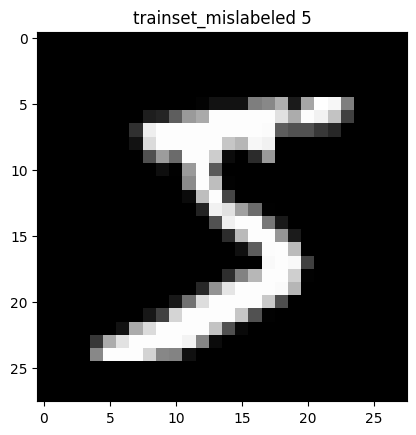

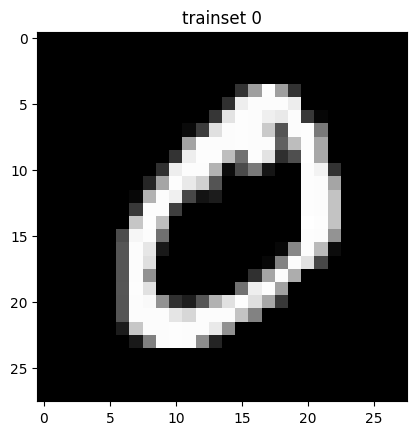

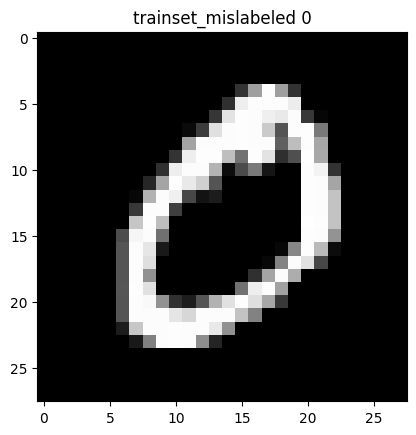

In [7]:
original_dataset_labels = mnist_trainset.targets
mislabeled_dataset_true_labels = mnist_trainset_mislabeled.true_labels
mislabeled_dataset_labels = mnist_trainset_mislabeled.labels

assert((original_dataset_labels == mislabeled_dataset_true_labels).all())
print("percent purposely mislabeled = ", 1 - (mislabeled_dataset_true_labels.numpy() == mislabeled_dataset_labels.numpy()).mean())

(mislabeled_dataset_true_labels.numpy() != mislabeled_dataset_labels.numpy())[:40]
print(np.arange(10), mislabeled_dataset_true_labels.numpy()[:30], mislabeled_dataset_labels.numpy()[:30], sep='\n')
for i in range(2):
  plt.imshow(mnist_trainset[i][0].squeeze().numpy(), cmap='gray')
  plt.title('trainset %i' % mnist_trainset.targets[i])
  plt.show()

  plt.imshow(mnist_trainset_mislabeled[i][0].squeeze().numpy(), cmap='gray')
  plt.title('trainset_mislabeled %i' % mnist_trainset_mislabeled.labels[i])
  plt.show()

# print('\n'*4 + "mnist_trainLoader:")
# for inputs, labels in mnist_trainLoader:
#     for input, label in zip(inputs, labels):
#         plt.imshow(input.squeeze().numpy(), cmap='gray')
#         plt.title('%i' % label)
#         plt.show()
#     break

In [8]:
class simpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn_layers = nn.Sequential(
            # 1st Conv Layer
            nn.Conv2d(1, 32, kernel_size=3, stride=1),
            nn.BatchNorm2d(32),
            # nn.ReLU(),
            # nn.MaxPool2d(2),
            # 2nd Conv Layer
            nn.Conv2d(32, 45, kernel_size=3, stride=1),
            nn.BatchNorm2d(45),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.15),
            # 3rd Conv Layer
            nn.Conv2d(45, 32, kernel_size=3, stride=1),
            nn.BatchNorm2d(32),
            # nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.15)
        )
        self.classifier = nn.Sequential(
          nn.Flatten(),
          nn.Linear(800, 100),
          nn.Dropout(0.3),
          nn.ReLU(),
          nn.Linear(100, 10)
        )

    def forward(self, x):
        # x = x.unsqueeze(1)
        x = self.cnn_layers(x)
        x = self.classifier(x)
        return x

class TDS_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn_layers = nn.Sequential(
            # 1st Conv Layer
            nn.Conv2d(1, 32, kernel_size=3, stride=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            # 2nd Conv Layer
            nn.Conv2d(32, 64, kernel_size=3, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(3)
        )
        self.classifier = nn.Sequential(
          nn.Flatten(),
          nn.Linear(4096, 250),
          nn.Dropout(0.3),
          nn.Sigmoid(),
          nn.Linear(250, 10)
        )

    def forward(self, x):
        # x = x.unsqueeze(1)
        x = self.cnn_layers(x)
        x = self.classifier(x)
        return x

In [9]:
# copied from Zan:

loaders = {'train':mnist_trainLoader, 'val':mnist_trainLoader} # NOTE: mnist does not have a val set
dataset_sizes = {'train':len(mnist_trainset), 'val':len(mnist_trainset)}

#Build Model
# model = torchvision.models.resnet18(pretrained=True).to(device)
model = simpleCNN().to(device)
torchsummary.summary(model, input_size=(1,28,28))
print("model architecture:", model)

for param in model.parameters():
    param.requires_grad = False

# print(model.fc)
# in_features = model.classifier.in_features # name of fc layer will change based on model
# print(in_features)
# model.classifier = nn.Linear(in_features, 10)


#save the losses for further visualization
losses = {'train':[], 'val':[]}
accuracies = {'train':[], 'val':[]}

#Hyperparameters
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr = 1e5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 4, gamma=0.1)
epochs = 30
epochs = 10

#Run Model
model.to(device)
# torchsummary.summary(model, input_size=(1,224,224))
# model = train(model, loaders, criterion, optimizer, scheduler, epochs)

# for inputs, labels in loaders['train']:
#     for input, label in zip(inputs, labels):
#         plt.imshow(input.squeeze().numpy(), cmap='gray')
#         plt.title('%i' % label)
#         plt.show()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
       BatchNorm2d-2           [-1, 32, 26, 26]              64
            Conv2d-3           [-1, 45, 24, 24]          13,005
       BatchNorm2d-4           [-1, 45, 24, 24]              90
              ReLU-5           [-1, 45, 24, 24]               0
         MaxPool2d-6           [-1, 45, 12, 12]               0
           Dropout-7           [-1, 45, 12, 12]               0
            Conv2d-8           [-1, 32, 10, 10]          12,992
       BatchNorm2d-9           [-1, 32, 10, 10]              64
        MaxPool2d-10             [-1, 32, 5, 5]               0
          Dropout-11             [-1, 32, 5, 5]               0
          Flatten-12                  [-1, 800]               0
           Linear-13                  [-1, 100]          80,100
          Dropout-14                  [

simpleCNN(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Conv2d(32, 45, kernel_size=(3, 3), stride=(1, 1))
    (3): BatchNorm2d(45, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Dropout(p=0.15, inplace=False)
    (7): Conv2d(45, 32, kernel_size=(3, 3), stride=(1, 1))
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Dropout(p=0.15, inplace=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=800, out_features=100, bias=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=10, bias=True)
 

In [15]:
# different training loop: https://pytorch.org/tutorials/beginner/introyt/trainingyt.html

from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
torch.set_grad_enabled(True)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
model.to(device)

def train_one_epoch(epoch_index, tb_writer, training_loader, loss_fn):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        torch.set_grad_enabled(True)
        # Every data instance is an input + label pair
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        inputs.requires_grad_(True)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = criterion(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()

        # original:
        # if i % 1000 == 999:
        #     last_loss = running_loss / 1000 # loss per batch
        #     print('  batch {} loss: {}'.format(i + 1, last_loss))
        #     tb_x = epoch_index * len(training_loader) + i + 1
        #     tb_writer.add_scalar('Loss/train', last_loss, tb_x)
        #     running_loss = 0.

        if i % 10 == 9:
            last_loss = running_loss / 10 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss


# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 5

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer, mnist_trainLoader, criterion)


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        # for i, vdata in enumerate(mnist_testLoader):
        for i, vdata in enumerate(mnist_trainLoader):
            vinputs, vlabels = vdata
            vinputs, vlabels = vinputs.to(device), vlabels.to(device)
            voutputs = model(vinputs)
            vloss = criterion(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:
  batch 10 loss: 2.3676928520202636
  batch 20 loss: 2.3763160943984984
  batch 30 loss: 2.3720549583435058
  batch 40 loss: 2.373073863983154
  batch 50 loss: 2.375227928161621
  batch 60 loss: 2.3709105253219604
LOSS train 2.3709105253219604 valid 2.3419082164764404
EPOCH 2:
  batch 10 loss: 2.366036534309387
  batch 20 loss: 2.3753545761108397
  batch 30 loss: 2.369306182861328
  batch 40 loss: 2.3827997207641602
  batch 50 loss: 2.3696105241775514
  batch 60 loss: 2.374944233894348
LOSS train 2.374944233894348 valid 2.341867208480835
EPOCH 3:
  batch 10 loss: 2.369976305961609
  batch 20 loss: 2.380207586288452
  batch 30 loss: 2.367825245857239
  batch 40 loss: 2.370363140106201
  batch 50 loss: 2.373736786842346
  batch 60 loss: 2.3762743711471557
LOSS train 2.3762743711471557 valid 2.341881275177002
EPOCH 4:
  batch 10 loss: 2.375156044960022
  batch 20 loss: 2.3747090816497805
  batch 30 loss: 2.37953462600708
  batch 40 loss: 2.3646235704421996
  batch 50 loss: 2.3762

test_loss: 2.3371, test_acc: 0.0997


<Figure size 640x480 with 0 Axes>

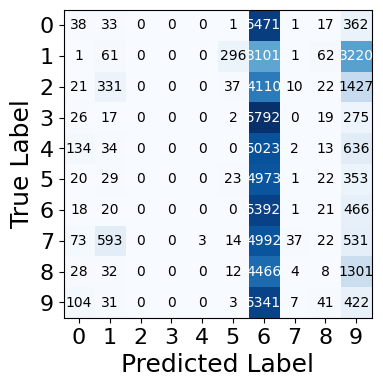

<Figure size 640x480 with 0 Axes>

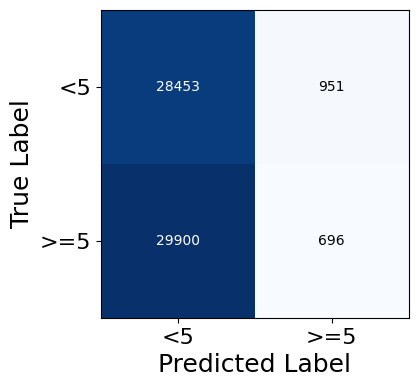

Accuracy of the model is 0.49
Recall of the model is 0.02
Precision of the model is 0.42
F1 Score of the model is 0.04


In [16]:
#Running on test data
model.to(device)
# preds,labels = test_predict(model, mnist_testLoader)
preds,labels = test_predict(model, mnist_trainLoader)


# Plot confusion matrix

cm  = confusion_matrix(labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(6,4),cmap=plt.cm.Blues)
plt.xticks(range(10), range(10), fontsize=16)
plt.yticks(range(10), range(10), fontsize=16)
plt.xlabel('Predicted Label',fontsize=18)
plt.ylabel('True Label',fontsize=18)
plt.show()

# binarize this (for now)
preds = (np.array(preds) < 5)
labels = (np.array(labels) < 5)

cm  = confusion_matrix(labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(6,4),cmap=plt.cm.Blues)
# plt.xticks(range(10), range(10), fontsize=16)
# plt.yticks(range(10), range(10), fontsize=16)
plt.xticks(range(2), ['<5', '>=5'], fontsize=16)
plt.yticks(range(2), ['<5', '>=5'], fontsize=16)
plt.xlabel('Predicted Label',fontsize=18)
plt.ylabel('True Label',fontsize=18)
plt.show()


# Compute Performance Metrics
tn, fp, fn, tp = cm.ravel()

accuracy_float = (np.array(preds) == np.array(labels)).sum() / len(preds)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2*((precision*recall)/(precision+recall))

print("Accuracy of the model is {:.2f}".format(accuracy_float))
print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))
print("F1 Score of the model is {:.2f}".format(f1))

In [ ]:
aled = ALED()
prob_df = aled.fit_predict(model=model, dataset=mnist_trainset, device=device, batch_size=1000)
# aled.prediction_stats.to_excel("drive/MyDrive/'Colab Notebooks'/MNIST/aled_prediction_stats.xlsx")
aled.prediction_stats[(aled.prediction_stats.iloc[:,:10] > 1).values.any(axis=1)]
aled.prediction_stats.iloc[:,10:]

,p(k = 0.0 | x),p(k = 1.0 | x),p(k = 2.0 | x),p(k = 3.0 | x),p(k = 4.0 | x),p(k = 5.0 | x),p(k = 6.0 | x),p(k = 7.0 | x),p(k = 8.0 | x),p(k = 9.0 | x),given label (name),out-label
0,1.451531e-01,2.670537e-08,0.135210,0.143340,0.093482,0.120226,0.111016,0.034022,0.120551,0.096999,5.0,5.0
1,1.918285e-01,1.235216e-09,0.131232,0.154177,0.068559,0.125889,0.100771,0.019510,0.127521,0.080513,0.0,0.0
2,1.898199e-05,5.166357e-05,0.025700,0.036942,0.200631,0.098892,0.075757,0.341147,0.026521,0.194341,4.0,4.0
3,5.829569e-13,7.930411e-01,0.000787,0.000614,0.003491,0.004823,0.011747,0.164171,0.001068,0.020258,1.0,1.0
4,6.534865e-03,5.080581e-07,0.070258,0.088345,0.216392,0.132258,0.100355,0.137052,0.067049,0.181756,9.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...
59995,1.928746e-01,9.205084e-16,0.123701,0.161896,0.030751,0.127198,0.105898,0.004522,0.189591,0.063569,8.0,8.0
59996,1.501058e-01,1.468273e-08,0.132815,0.145132,0.091389,0.123288,0.108641,0.031728,0.120824,0.096078,3.0,3.0
59997,1.893822e-03,1.207280e-07,0.049972,0.075507,0.249849,0.132756,0.088907,0.155640,0.051875,0.193601,5.0,5.0
59998,2.233990e-01,1.405139e-17,0.115405,0.144218,0.033427,0.105715,0.111429,0.004008,0.196305,0.066093,6.0,0.0


## Zan's pneumonia dataset setup

**Dataset** Setup

In [ ]:
TEST = 'test'
TRAIN = 'train'
VAL ='val'

trainset = datasets.ImageFolder(os.path.join(data_dir, TRAIN),transform = data_transforms(TRAIN))
testset = datasets.ImageFolder(os.path.join(data_dir, TEST),transform = data_transforms(TEST))
validset = datasets.ImageFolder(os.path.join(data_dir, VAL),transform = data_transforms(VAL))

class_names = trainset.classes
print(class_names)
print(trainset.class_to_idx)

BATCH_SIZE = 4

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE, shuffle = False)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle = False)
loaders = {'train':trainloader, 'val':validloader}
dataset_sizes = {'train':len(trainset), 'val':len(validset)}



images, labels = iter(trainloader).next()
print(images.shape)
print(labels.shape)

Initial Model Build

In [ ]:
#Build Model
model = torchvision.models.densenet161(pretrained=True)


for param in model.parameters():
    param.requires_grad = False

in_features = model.classifier.in_features
print(in_features)
model.classifier = nn.Linear(in_features, 2)


#save the losses for further visualization
losses = {'train':[], 'val':[]}
accuracies = {'train':[], 'val':[]}

#Hyperparameters
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr = 0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 4, gamma=0.1)
epochs = 30
epochs = 2

#Run Model
model.to(device)
model = train(model, criterion, optimizer, scheduler, epochs)

Run On Test Data

In [ ]:
#Running on test data
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle = False)
model.to(device)
preds,labels = test_predict(model, testloader)




# Plot confusion matrix
cm  = confusion_matrix(labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8),cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.xlabel('Predicted Label',fontsize=18)
plt.ylabel('True Label',fontsize=18)
plt.show()



# Compute Performance Metrics
tn, fp, fn, tp = cm.ravel()

accuracy = (np.array(preds) == np.array(labels)).sum() / len(preds)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2*((precision*recall)/(precision+recall))

print("Accuracy of the model is {:.2f}".format(accuracy))
print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))
print("F1 Score of the model is {:.2f}".format(f1))

In [ ]:
aled = ALED()
prob_df = aled.fit(model=model, data=trainset, data_transforms=data_transforms(TRAIN))

In [ ]:
data_df = pd.DataFrame(trainset.imgs, columns=["img", "label"])
data_df["true_labels"] = data_df["img"].apply(lambda x : 1 if "person" in x else 0)

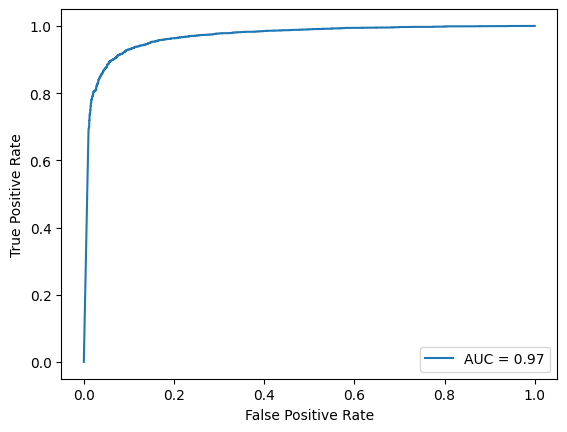

In [ ]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(data_df["true_labels"].to_numpy(), prob_df["p(k = PNEUMONIA | x)"].to_numpy())
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr,tpr=tpr, roc_auc=roc_auc)
display.plot()

In [ ]:
img_paths = np.array(trainset.imgs)[:, 0]
suspected_class0_mislabels = img_paths[np.array(prob_df[(prob_df["p(k = PNEUMONIA | x)"] > 0.95) & (prob_df["given label (num)"] == 0)].index)]
suspected_class1_mislabels = img_paths[np.array(prob_df[(prob_df["p(k = PNEUMONIA | x)"] < 0.05) & (prob_df["given label (num)"] == 1)].index)]

In [ ]:
moving_path = "C:\\Users\\Small\\OneDrive\\Documents\\Cleanlab Testing\\test_10_to_1\\suspected_mislabels"

for path in suspected_class0_mislabels:
    moving_path_new = moving_path + "\\class0"
    filename = path.split("\\")[-1]
    new_fname = moving_path_new + "\\" + filename
    os.rename(path, new_fname)

for path in suspected_class1_mislabels:
    moving_path_new = moving_path + "\\class1"
    filename = path.split("\\")[-1]
    new_fname = moving_path_new + "\\" + filename
    os.rename(path, new_fname)

Redefine Dataset and Try Again!

In [ ]:
trainset = datasets.ImageFolder(os.path.join(data_dir, TRAIN),transform = data_transforms(TRAIN))
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle = True)
loaders = {'train':trainloader, 'val':validloader}
dataset_sizes = {'train':len(trainset), 'val':len(validset)}

model = train(model, criterion, optimizer, scheduler, epochs)

Epoch: 1/2
train - loss:0.16723413031764195, accuracy0.9415791875855773
val - loss:0.552920245565474, accuracy0.6875
Time: 1.0m 58.72190618515015s
Epoch: 2/2
train - loss:0.14858160792268785, accuracy0.942035600182565
val - loss:0.5343702156096697, accuracy0.75
Time: 3.0m 54.051937103271484s
Training Time 3.0m 54.16115880012512s
Best accuracy 0.75


test_loss: 0.2986, test_acc: 0.8958


<Figure size 640x480 with 0 Axes>

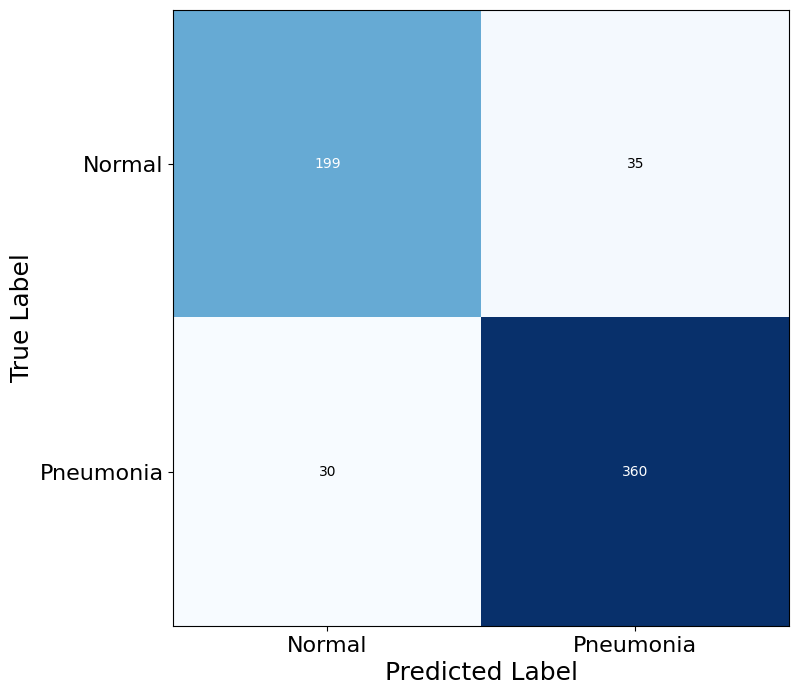

Accuracy of the model is 0.90
Recall of the model is 0.92
Precision of the model is 0.91
F1 Score of the model is 0.92


In [ ]:
#Running on test data
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle = False)
model.to(device)
preds,labels = test_predict(model, testloader)




# Plot confusion matrix
cm  = confusion_matrix(labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8),cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.xlabel('Predicted Label',fontsize=18)
plt.ylabel('True Label',fontsize=18)
plt.show()



# Compute Performance Metrics
tn, fp, fn, tp = cm.ravel()

accuracy = (np.array(preds) == np.array(labels)).sum() / len(preds)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2*((precision*recall)/(precision+recall))

print("Accuracy of the model is {:.2f}".format(accuracy))
print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))
print("F1 Score of the model is {:.2f}".format(f1))

Additional Training

In [ ]:
# #Retrain rest of model
for param in model.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
#print(torch.cuda.memory_summary(device))
#torch.cuda.empty_cache()

model.to(device)
grad_clip = None
weight_decay = 1e-4
  #weighted loss for data class imbalance
epochs = 30
epochs = 2
model = train(model, criterion, optimizer, scheduler, epochs)

Rechecking Mislabeled Data

In [ ]:
checking_path = moving_path
checkset = torchvision.datasets.ImageFolder(checking_path)
check_data_df = pd.DataFrame(checkset.imgs, columns=["img", "label"])

In [ ]:
for param in model.parameters():
    param.requires_grad = False
aled2 = ALED()
check_df = aled2.fit(model=model, data=checkset, data_transforms=data_transforms(TRAIN))